In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sympy import *
from tqdm.notebook import tqdm

In [3]:
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

train_full = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_full = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [5]:
class BinaryData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.from_numpy(x_data)
        self.y_data = torch.from_numpy(y_data).type(torch.LongTensor)
        self.len = len(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [6]:
# Get indices of samples associated to filtered_classes
class_names = train_full.classes
filtered_classes = ['3 - three', '6 - six']
filtered_labels=[class_names.index(cl) for cl in filtered_classes]

train_data = {'x':[], 'y':[]}
for xdata, ydata in train_full:  
    if ydata in filtered_labels:
        train_data['x'].append(xdata.numpy())
        if filtered_labels.index(ydata) == 0:
            train_data['y'].append(0)
        else:
            train_data['y'].append(1)
        
test_data = {'x':[], 'y':[]}
for xdata, ydata in test_full:  
    if ydata in filtered_labels:
        test_data['x'].append(xdata.numpy())
        if filtered_labels.index(ydata) == 0:
            test_data['y'].append(0)
        else:
            test_data['y'].append(1)

In [7]:
train_dataset = BinaryData(np.array(train_data['x']), np.array(train_data['y']))
test_dataset = BinaryData(np.array(test_data['x']), np.array(test_data['y']))

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
# Temporal Dynamics
num_steps = 25
beta = 0.99

# Quantum Spike Neural Network

In [11]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp, AerPauliExpectation
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.utils import QuantumInstance, algorithm_globals

In [12]:
class QuantumCircuit_simulator:
    def __init__(self):
#         self._circuit = qiskit.QuantumCircuit(n_qubits)
        
#         all_qubits = [i for i in range(n_qubits)]
#         self.theta = qiskit.circuit.Parameter('theta')
        self.theta = symbols('theta')
        self.Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128).to(device)
        self.H = torch.tensor([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]], dtype=torch.complex128).to(device)
        self.init_state = torch.tensor([1,0], dtype=torch.complex128).to(device)
        self.init_state = torch.matmul(self.H, self.init_state).reshape(-1,1).to(device)
#         self._circuit.h(all_qubits)
#         self._circuit.barrier()
#         self._circuit.ry(self.theta, all_qubits)
        
#         self._circuit.measure_all()

#         self.backend = backend
#         self.shots = shots
    
    def run(self, thetas):
        cosines = torch.cos(thetas/2)
        sines = torch.sin(thetas/2)
        Rys = [ torch.tensor([[c, -s], [s,c]], dtype=torch.complex128) for c, s in zip(cosines, sines) ]
        Rys = torch.stack(Rys, axis=0).to(device)
        
        out_states = torch.einsum("ikj, jl -> ikl", Rys, self.init_state)
        out_probs = (out_states**2).real.squeeze().float()
        
        states = torch.tensor([0., 1.]).to(device)
#         states = np.array(list(result.keys())).astype(float)
#         states = 2*(states - 0.5)
        # Compute probabilities for each state
#         probabilities = counts / self.shots
        # Get state expectation
        exps = torch.matmul(out_probs, states)
        
        return exps
    
    def get_grad(self, thetas):
        return torch.cos(thetas/2)**2 - torch.sin(thetas/2)**2

In [13]:
circuit_simulator = QuantumCircuit_simulator()
print('Expected value for rotation pi {}'.format(circuit_simulator.run(torch.ones(10))))
# circuit._circuit.draw('mpl')

Expected value for rotation pi tensor([0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207,
        0.9207])


In [15]:
class HybridFunction(torch.autograd.Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        result_exp = ctx.quantum_circuit.run(inputs)
        ctx.save_for_backward(inputs, result_exp)

        return result_exp
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        inputs, result_exp = ctx.saved_tensors
#         input_list = np.array(inputs.tolist())
        gradients = ctx.quantum_circuit.get_grad(inputs)
        
#         shift_right = inputs + torch.ones(inputs.shape) * ctx.shift
#         shift_left = inputs - np.ones(inputs.shape) * ctx.shift

#         expectation_right = ctx.quantum_circuit.run(shift_right)
#         expectation_left  = ctx.quantum_circuit.run(shift_left)
#         gradients = expectation_right - expectation_left
#         print((grad_output.float() ).shape)
        return (gradients.squeeze().float() * grad_output.float()).reshape(-1,1), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit_simulator()
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [16]:
# Define Network
class Hybrid_qsnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 100)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(100, 10)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(10, 1)
        self.hybrid = Hybrid(np.pi / 2)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        summed_spk = torch.stack(spk2_rec, dim=0).sum(axis=0)
        q_in = self.fc3(summed_spk)
        x1 = self.hybrid(q_in)
        x0 = 1 - x1
        out = torch.cat((x0.reshape(-1,1),x1.reshape(-1,1)), axis=1)
        return out

# net = Hybrid_qsnn().to(device)

In [17]:
num_param = 0
for p in net.parameters():
    mul = 1
    for num in list(p.shape):
        mul *= num
    num_param += mul
print(num_param)

79521


In [30]:
def training(net, model='qsnn'):
    dataset_sizes = train_loader.dataset.len
    test_dataset_sizes = test_loader.dataset.len
        
    loss = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-5)

    num_epochs = 10
    loss_hist = []
    test_loss_hist = []
    acc_hist = []
    test_acc_hist = []
    best_test_acc = 0

    # Outer training loop
    for epoch in tqdm(range(num_epochs), leave=False):
        train_batch = iter(train_loader)

        train_loss, test_loss = 0, 0
        train_acc, test_acc = 0, 0
        # Minibatch training loop
        for it, (data, targets) in tqdm(enumerate(train_batch),leave=False):
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            if model =='qsnn':
                preds = net(data.view(len(data), -1))
            elif model =='qcnn':
                preds = net(data)
    #         print(preds)
            # initialize the loss & sum over time
            loss_val = loss(preds, targets)
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if model =='qsnn':
                preds = net(data.view(len(data), -1))
            elif model =='qcnn':
                preds = net(data)
            _, idx =  preds.max(1)
            acc = np.sum((targets == idx).detach().cpu().numpy())
            train_acc += acc
            train_loss += loss_val.item() * len(data)

#         print(f"Epoch {epoch}, Iteration {it}")
#         print(f"Train Set Loss: {train_loss / dataset_sizes:.2f}")
#         print(f"Train set accuracy: {train_acc/dataset_sizes*100:.2f}%")

        # Test set
        with torch.no_grad():
            net.eval()
            test_batch = iter(test_loader)
            for it, (test_data, test_targets) in tqdm(enumerate(test_batch),leave=False):

                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Test set forward pass
                if model =='qsnn':
                    test_preds = net(test_data.view(len(test_data), -1))
                elif model =='qcnn':
                    test_preds = net(test_data)

                # Test set loss
    #             test_loss = torch.zeros((1), dtype=dtype, device=device)
                test_loss += loss(test_preds, test_targets).item() * len(test_data)

                _, idx = test_preds.max(1)
                acc = np.sum((test_targets == idx).detach().cpu().numpy())
                test_acc += acc

#             print(f"Test Set Loss: {test_loss / test_loader.dataset.len:.2f}")
#             print(f"Test set accuracy: {test_acc/test_loader.dataset.len*100:.2f}%")

        # Store loss history for future plotting
        loss_hist.append(train_loss / dataset_sizes)
        test_loss_hist.append(test_loss / test_dataset_sizes)

        acc_hist.append(train_acc / dataset_sizes)
        test_acc_hist.append(test_acc / test_dataset_sizes)
        
        if test_acc_hist[-1] > best_test_acc:
            best_test_acc = test_acc_hist[-1]
            best_model_state = net.state_dict()
            print('best model updated / Acc: ', best_test_acc)
    
    return loss_hist.copy(), test_loss_hist.copy(), acc_hist.copy(), test_acc_hist.copy(), best_model_state

In [19]:
data_dict = {}
data_dict['train_loss'], data_dict['test_loss'] = [], []
data_dict['train_acc'], data_dict['test_acc'] = [], []
data_dict['best_model'] = []
for i in tqdm(range(10)):
    net = Hybrid_qsnn().to(device)
    lh, tlh, ah, tah, bm = training(net, model='qsnn')
    data_dict['train_loss'].append(lh)
    data_dict['test_loss'].append(tlh)
    data_dict['train_acc'].append(ah)
    data_dict['test_acc'].append(tah)
    data_dict['best_model'].append(bm)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.595020325203252


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9400406504065041


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9557926829268293


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9629065040650406


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9634146341463414


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9659552845528455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.967479674796748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9695121951219512


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.970020325203252


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9705284552845529


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.7667682926829268


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9217479674796748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9425813008130082


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9547764227642277


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9629065040650406


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9649390243902439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9684959349593496


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9695121951219512


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.7830284552845529


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9298780487804879


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9542682926829268


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9613821138211383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9639227642276422


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9659552845528455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9664634146341463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9684959349593496


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.970020325203252


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9705284552845529


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.782520325203252


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9126016260162602


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9339430894308943


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.948170731707317


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9507113821138211


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9547764227642277


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9578252032520326


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9608739837398373


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9649390243902439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8755081300813008


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9400406504065041


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.953760162601626


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9608739837398373


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9664634146341463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.967479674796748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9710365853658537


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9720528455284553


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.7306910569105691


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9380081300813008


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9522357723577236


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9578252032520326


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9629065040650406


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9644308943089431


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9654471544715447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9679878048780488


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9690040650406504


0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8434959349593496


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9476626016260162


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.959349593495935


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9644308943089431


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9669715447154471


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9690040650406504


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.970020325203252


0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9105691056910569


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9451219512195121


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9527439024390244


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9613821138211383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9664634146341463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.967479674796748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9690040650406504


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9695121951219512


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.970020325203252


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8597560975609756


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9486788617886179


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9603658536585366


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9669715447154471


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.967479674796748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9695121951219512


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9705284552845529


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9715447154471545


0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8567073170731707


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9547764227642277


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9623983739837398


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9649390243902439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9659552845528455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9679878048780488


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9690040650406504


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.970020325203252


In [20]:
import pickle

with open('QSNN.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

# Quantum Convoulutional Neural Network

In [27]:
# Define Network
class Hybrid_qcnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=5, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels = 5, out_channels=15, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(24*24*15, 10)
        self.fc2 = nn.Linear(10, 1)
        self.hybrid = Hybrid(np.pi / 2)

    def forward(self, x):
        lendata = len(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(lendata, -1)
        x = F.relu(self.fc1(x))
        q_in = self.fc2(x)        
        x1 = self.hybrid(q_in)
#         x = [self.hybrid(summed_spk[i]) for i in range(len(summed_spk))]
#         x1 = torch.cat(x)
        x0 = 1 - x1
        out = torch.cat((x0.reshape(-1,1),x1.reshape(-1,1)), axis=1)
        return out

# net = Hybrid_qcnn().to(device)

In [28]:
num_param = 0
for p in net.parameters():
    mul = 1
    for num in list(p.shape):
        mul *= num
    num_param += mul
print(num_param)

87161


In [32]:
data_dict = {}
data_dict['train_loss'], data_dict['test_loss'] = [], []
data_dict['train_acc'], data_dict['test_acc'] = [], []
data_dict['best_model'] = []
for i in tqdm(range(10)):
    net = Hybrid_qcnn().to(device)
    lh, tlh, ah, tah, bm = training(net, model='qcnn')
    data_dict['train_loss'].append(lh)
    data_dict['test_loss'].append(tlh)
    data_dict['train_acc'].append(ah)
    data_dict['test_acc'].append(tah)
    data_dict['best_model'].append(bm)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.5045731707317073


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.7713414634146342


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9298780487804879


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9603658536585366


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9669715447154471


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.47510162601626016


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.4766260162601626


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.5889227642276422


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.818089430894309


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9065040650406504


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9354674796747967


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9517276422764228


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9623983739837398


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9639227642276422


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9110772357723578


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.948170731707317


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9512195121951219


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9522357723577236


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9557926829268293


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9563008130081301


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9588414634146342


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9598577235772358


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9608739837398373


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.5020325203252033


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.5066056910569106


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8084349593495935


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9115853658536586


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9476626016260162


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9598577235772358


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9613821138211383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9634146341463414


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9644308943089431


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.5020325203252033


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.7276422764227642


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8938008130081301


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9441056910569106


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9603658536585366


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9654471544715447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.967479674796748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.4766260162601626


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.5960365853658537


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.850609756097561


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9161585365853658


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9451219512195121


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9568089430894309


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9613821138211383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9649390243902439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9659552845528455


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.7007113821138211


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9344512195121951


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.49441056910569103


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8922764227642277


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9446138211382114


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9527439024390244


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9547764227642277


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9563008130081301


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9568089430894309


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.4725609756097561


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.4730691056910569


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.5655487804878049


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8175813008130082


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.904979674796748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9435975609756098


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9512195121951219


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9542682926829268


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.4720528455284553


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.8277439024390244


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9461382113821138


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9563008130081301


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9613821138211383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.961890243902439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9634146341463414


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model updated / Acc:  0.9639227642276422


In [33]:
import pickle

with open('QCNN.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [34]:
with open('QSNN.pkl', 'rb') as f:
    qsnn_data = pickle.load(f)
with open('QCNN.pkl', 'rb') as f:
    qcnn_data = pickle.load(f)
datas = {}
datas['qsnn'] = qsnn_data
datas['qcnn'] = qcnn_data
colors = {'qsnn':'red', 'qcnn':'green'}

In [35]:
qsnn_data.keys()

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc', 'best_model'])

In [36]:
def plotter(title, plot_type, ylabel):
    for k in datas.keys():
        mu = np.array(datas[k][plot_type]).mean(axis=0)
        plt.plot(range(10), mu, c=colors[k], label=k)
        std = np.array(datas[k][plot_type]).std(axis=0)
        plt.fill_between(range(10),mu-std, mu+std, color=colors[k], alpha=0.2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

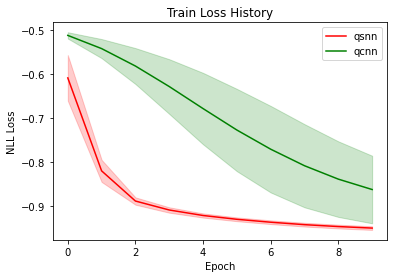

In [37]:
plotter('Train Loss History', 'train_loss', 'NLL Loss')

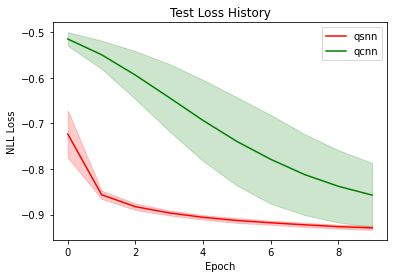

In [38]:
plotter('Test Loss History', 'test_loss', 'NLL Loss')

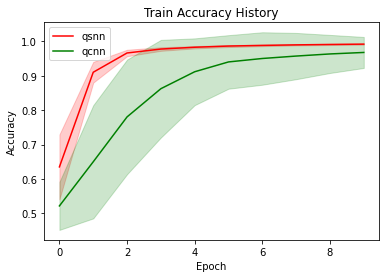

In [39]:
plotter('Train Accuracy History', 'train_acc', 'Accuracy')

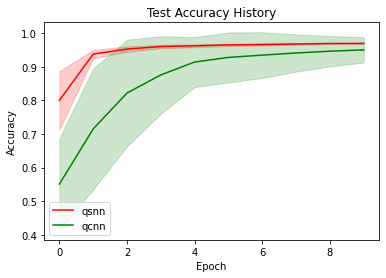

In [40]:
plotter('Test Accuracy History', 'test_acc', 'Accuracy')

# QSNN on Real Quantum Device

In [41]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
ibm_token = '49670f985b02b984d52967234a8d86aa4f49519731f6a3b1b9b5c2afffde9d8f34d46e6df77cf8ec96e1adf36aadeaf8a6c4a73665cfb2945627ed954451f473' # https://quantum-computing.ibm.com/account
ibmq_account = IBMQ.enable_account(ibm_token)

In [42]:
ibmq_provider = IBMQ.get_provider(hub='ibm-q-skku', group='snu', project='snu-graduate')
ibmq_backend = ibmq_provider.get_backend('ibm_perth')

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')

In [43]:
print([max(d) for d in datas['qsnn']['test_acc']])

[0.9705284552845529, 0.9695121951219512, 0.9705284552845529, 0.9649390243902439, 0.9720528455284553, 0.9690040650406504, 0.970020325203252, 0.970020325203252, 0.9715447154471545, 0.970020325203252]


In [44]:
best_statedict = datas['qsnn']['best_model'][4]

In [45]:
class QuantumCircuit:
    def __init__(self, backend, n_qubits=1, shots=256):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        thetas = thetas.tolist()
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots,
                        parameter_binds = [{self.theta: theta[0]} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        for r in result:
            if '0' not in r.keys():
                r['0'] = 0
            elif '1' not in r.keys():
                r['1'] = 0
            
        return result

In [47]:
# Define Network
class Hybrid_qsnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 100)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(100, 10)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(10, 1)
        self.qc = QuantumCircuit(ibmq_backend)
#         self.qc = QuantumCircuit(simulator)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        summed_spk = torch.stack(spk2_rec, dim=0).sum(axis=0)
        q_in = self.fc3(summed_spk)
        out = self.qc.run(q_in)
        return out

In [48]:
model = Hybrid_qsnn().to(device)
model.load_state_dict(best_statedict)
model.eval()

Hybrid_qsnn(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
test_x, test_y = next(iter(test_loader))

In [ ]:
model(test_x.view(len(test_x), -1))

<ipython-input-45-0526d52f7620>:21: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = self.backend.run(qobj)
